In [1]:
import pandas as pd
import numpy as np

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import Sequence
from keras.callbacks import TensorBoard, Callback
from keras.optimizers import SGD, Adam
from keras import backend as K

Using TensorFlow backend.


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight #UPDATE 28/11
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import sys
import os

In [6]:
from nltk import FreqDist
from nltk import word_tokenize
import seaborn as sns

# Carga de datos

In [7]:
df_folder = "10"

In [8]:
q_data = pd.read_csv(os.path.join(df_folder, "Questions.csv"),encoding='latin1')

In [9]:
t_data = pd.read_csv(os.path.join(df_folder,"Tags.csv"),encoding='latin1')

In [10]:
a_data = pd.read_csv(os.path.join(df_folder,"Answers.csv"),encoding='latin1')

# Exploración

Exploración básica

#### atributos a referenciar:


In [11]:
c_question = "Body"
c_title = "Title"
c_id = "Id"

In [12]:
display("Questions")
display(q_data.head())
display(q_data.shape)
display("Tags")
display(t_data.head())
display(t_data.shape)
display("Answers")
display(a_data.head())
display(a_data.shape)

'Questions'

,Unnamed: 0,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,345874,12395950,795000.0,2012-09-12T20:45:35Z,2016-10-05T20:53:44Z,2,Calling Twain driver from 64 bit application,<p>I need to call TWAIN API from .NET (C#) app...
1,654403,22426350,1378959.0,2014-03-15T16:17:17Z,NaN,0,Why does variable in struct instance change af...,<p>This is really weird.</p>\r\n\r\n<p>I have ...
2,574386,19842160,2429569.0,2013-11-07T17:07:34Z,NaN,0,dynamically creating text fields lands up in d...,"<p>I'm having issues with the below code,\r\nw..."
3,671187,22953000,3513576.0,2014-04-09T04:48:04Z,NaN,0,Javascript in PHP/HTML hiding Div not working,<p>I am new to coding so be gentle. I am buil...
4,1088725,35528560,1712334.0,2016-02-20T20:24:29Z,NaN,0,Design a compareTo that can sort in ascending ...,<p>I have a class States that is an object tha...


(126422, 8)

'Tags'

,Unnamed: 0,Id,Tag
0,10,180,algorithm
1,11,180,language-agnostic
2,12,180,colors
3,13,180,color-space
4,31,810,windows


(374632, 3)

'Answers'

,Unnamed: 0,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
1,9,529,86.0,2008-08-02T18:16:07Z,180,3,<p>Isn't it also a factor which order you set ...
2,10,539,157.0,2008-08-02T19:03:52Z,180,21,"<p>My first thought on this is ""how generate N..."
3,18,818,233.0,2008-08-03T20:45:27Z,810,0,<p>I'm partway to my solution with this entry ...
4,19,820,91.0,2008-08-03T20:48:47Z,810,3,"<p>First: Yes, this is something that belongs ..."


(200926, 7)

In [13]:
def plot_top_words(indexes, data, top_number=10, title=''):
    zipo = zip(indexes, data)
    sorted_by_second = sorted(zipo, key=lambda tup: tup[1])
    words = [word for word,_ in sorted_by_second]
    values = [value for _,value in sorted_by_second]
    chart = sns.barplot(x=words[-top_number:], y=values[-top_number:])
    if title != '':
        chart.set_title(title)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [14]:
def get_top_tags():
    popular = t_data.Tag.value_counts()
    return list(zip(popular.index, popular))

[('javascript', 12265),
 ('java', 11539),
 ('c#', 10022),
 ('php', 9824),
 ('android', 9205),
 ('jquery', 7848),
 ('python', 6477),
 ('html', 5987),
 ('ios', 4701),
 ('c++', 4678),
 ('mysql', 4357),
 ('css', 4308),
 ('sql', 3719),
 ('asp.net', 2929),
 ('objective-c', 2636),
 ('ruby-on-rails', 2580),
 ('.net', 2437),
 ('c', 2268),
 ('iphone', 2109),
 ('angularjs', 1994),
 ('arrays', 1967),
 ('sql-server', 1818),
 ('json', 1707),
 ('ruby', 1664),
 ('r', 1566)]

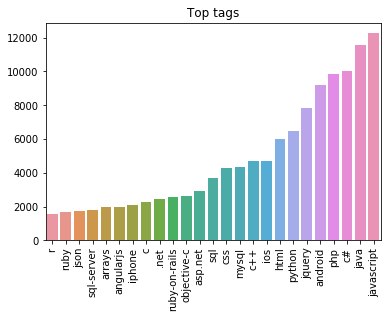

In [15]:
top_tags_count = get_top_tags()
display(top_tags_count[:25])
top_tags = [i for i,j in top_tags_count][:25]
top_tags_values = [j for _,j in top_tags_count][:25]
plot_top_words(top_tags, top_tags_values,25,'Top tags')


## Definición de word stemmer

In [16]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

stemmer = SnowballStemmer(language = 'english')
analyzer = CountVectorizer().build_analyzer()

stop_words = stopwords.words('english')

def stemmed_words(doc):
    return (stemmer.stem(w.lower()) for w in analyzer(doc) if w not in stop_words)

# Más Exploración

Se debe realizar la siguiente exploración sobre las preguntas:
- Histograma del largo de las preguntas
- Histograma de las frecuencias de palabras de las preguntas (limitando el número de palabras)
- Histograma de frecuencias de los tags

In [17]:
import matplotlib.pyplot as plt
 
def plot_hist(data, num_bins  = 50):
    max_length = data.max
    hist, bins = np.histogram(data, bins=num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.show()
    plt

### Largo de las preguntas

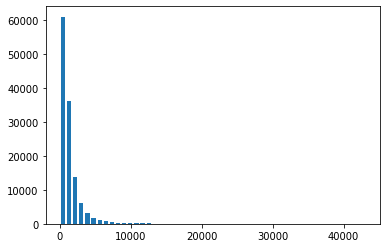

In [18]:
lengths = q_data[c_question].apply(lambda x : len(x))
plot_hist(lengths)

### Frecuencia de palabras en body

In [19]:
flatten = lambda l: [item for sublist in l for item in sublist]

def all_words_frequency(corpus):
    text_lists = map(lambda x : x.split(" "), corpus) 
    words = flatten(text_lists)
    words = filter(lambda x: x != "", words)
    return FreqDist(words)

/home/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/marcel/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


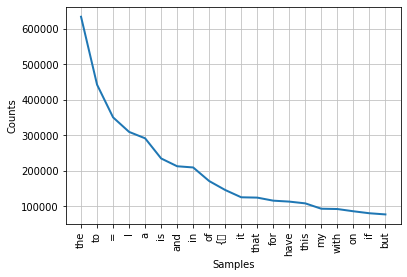

In [20]:
freq_all_words_body = all_words_frequency(q_data.Body)
freq_all_words_body.plot(20)

### Frecuencia de tags literales en body

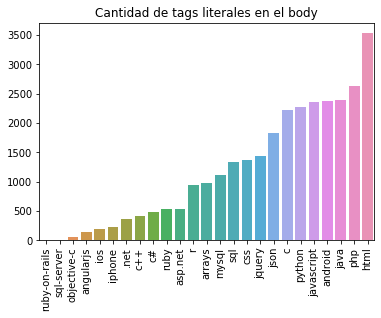

In [21]:
frequency_tags_all_body = [freq_all_words_body[tag] for tag in top_tags]
plot_top_words(top_tags, frequency_tags_all_body, 25,"Cantidad de tags literales en el body")

### Frecuencia de palabras en title

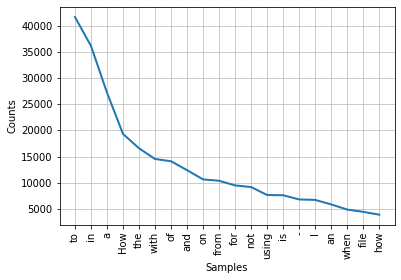

In [22]:
freq_all_words_title = all_words_frequency(q_data.Title)
freq_all_words_title.plot(20)

### Frecuencia de tags literales en title

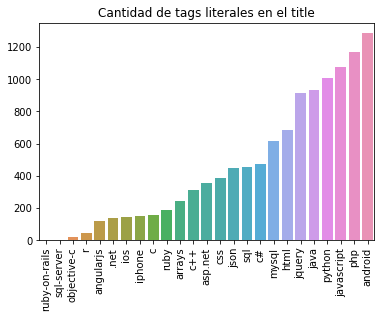

In [23]:
frequency_tags_all_title = [freq_all_words_title[tag] for tag in top_tags]
plot_top_words(top_tags, frequency_tags_all_title, 25,"Cantidad de tags literales en el title")

# Preoprocesamiento target value

Los tags y las questions son dataframes distintos. Es necesario hacer un join y combinarlas.

In [24]:
#Genera todos los pares posibles existentes entre las preguntas y los tags
def generate_question_tag_pairs(top_tags):
    top_tags_set = set()
    for _, row in t_data[t_data.Tag.isin(top_tags)].iterrows():
        top_tags_set.add(str(row["Id"]) + "-" + row["Tag"])
    return top_tags_set

In [25]:
top_tags_set = generate_question_tag_pairs(top_tags)

In [26]:
#Agrega las tags al df de las questions
def add_tags_to_questions(questions_df, tags, top_tags_set):
    def contains_tag(tag):
        def _contains(ID):
            return (str(ID) + "-" + tag) in top_tags_set
        return _contains
    
    q_tags_columns = []
    for tag in list(tags):
        columnName = "t_" + tag
        questions_df[columnName] = questions_df["Id"].map(contains_tag(tag))

        q_tags_columns.append(columnName)
    return q_tags_columns

In [27]:
import seaborn as sns
def explore_tags(df):
    df = df.copy()
    q_tags_columns = add_tags_to_questions(df, top_tags, top_tags_set)
    true_tag_count = []
    false_tag_count = []
    for tag in q_tags_columns:
        tag_count = df[tag].value_counts()
        false_tag_count.append(tag_count[0])
        true_tag_count.append(tag_count[1])
        sns.barplot(x=['False', 'True'], y=tag_count).set_title(tag[2:])
        plt.figure()
    q_tags_names = map(lambda tag: tag[2:], q_tags_columns)
    true_chart = sns.barplot(x=q_tags_names, y=true_tag_count)
    true_chart.set_title("True tags")
    true_chart.set_xticklabels(true_chart.get_xticklabels(), rotation=90)
    plt.figure()
    false_chart = sns.barplot(x=q_tags_names, y=false_tag_count)
    false_chart.set_title("False tags")
    false_chart.set_xticklabels(false_chart.get_xticklabels(), rotation=90)
    plt.figure()

In [28]:
add_tags_to_questions(q_data, top_tags, top_tags_set)
q_data

,Unnamed: 0,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,t_javascript,t_java,...,t_ruby-on-rails,t_.net,t_c,t_iphone,t_angularjs,t_arrays,t_sql-server,t_json,t_ruby,t_r
0,345874,12395950,795000.0,2012-09-12T20:45:35Z,2016-10-05T20:53:44Z,2,Calling Twain driver from 64 bit application,<p>I need to call TWAIN API from .NET (C#) app...,False,False,...,False,True,False,False,False,False,False,False,False,False
1,654403,22426350,1378959.0,2014-03-15T16:17:17Z,NaN,0,Why does variable in struct instance change af...,<p>This is really weird.</p>\r\n\r\n<p>I have ...,False,False,...,False,False,True,False,False,False,False,False,False,False
2,574386,19842160,2429569.0,2013-11-07T17:07:34Z,NaN,0,dynamically creating text fields lands up in d...,"<p>I'm having issues with the below code,\r\nw...",True,False,...,False,False,False,False,False,False,False,False,False,False
3,671187,22953000,3513576.0,2014-04-09T04:48:04Z,NaN,0,Javascript in PHP/HTML hiding Div not working,<p>I am new to coding so be gentle. I am buil...,True,False,...,False,False,False,False,False,False,False,False,False,False
4,1088725,35528560,1712334.0,2016-02-20T20:24:29Z,NaN,0,Design a compareTo that can sort in ascending ...,<p>I have a class States that is an object tha...,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126417,774493,26196410,3948823.0,2014-10-04T19:34:01Z,NaN,1,Trying to download a file using FileUtils,<p>I'm using this atm:</p>\r\n\r\n<pre><code>p...,False,True,...,False,False,False,False,False,False,False,False,False,False
126418,516752,17962250,2618142.0,2013-07-31T05:25:50Z,NaN,0,ffdec_h264 (video decoder) GstElement not foun...,<p>Some of the lines from a <em>MyApp.c</em> f...,False,False,...,False,False,False,False,False,False,False,False,False,False
126419,35874,1795880,171406.0,2009-11-25T10:03:26Z,NaN,0,significance of 'z'?,<p>i started out learning cocos2d and came acr...,False,False,...,False,False,False,True,False,False,False,False,False,False
126420,341956,12265770,1607247.0,2012-09-04T14:34:57Z,NaN,1,How to use key word from a current line of tex...,<p>I am starting out in Perl and am parsing so...,False,False,...,False,False,False,False,False,False,False,False,False,False


/home/marcel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


TypeError: object of type 'map' has no len()

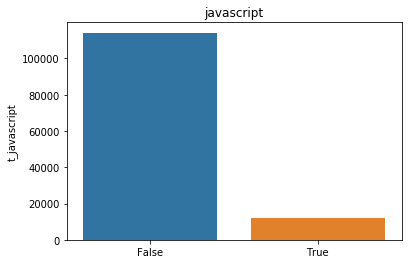

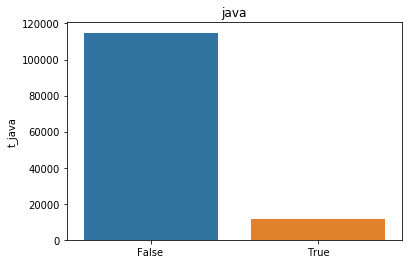

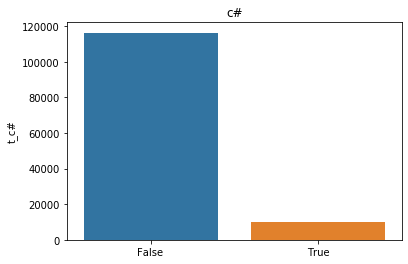

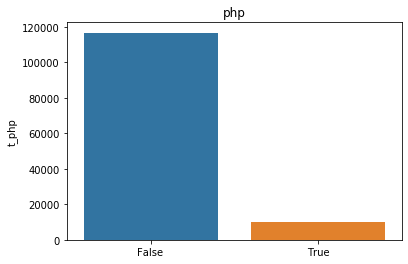

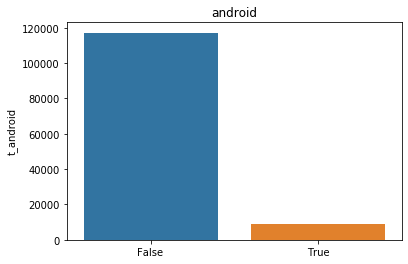

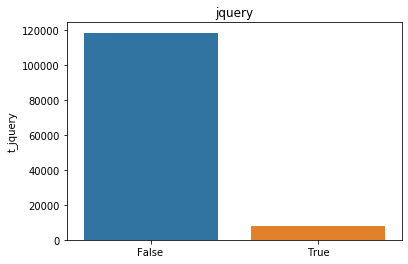

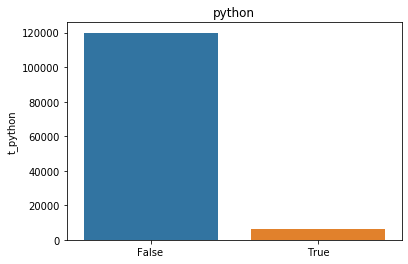

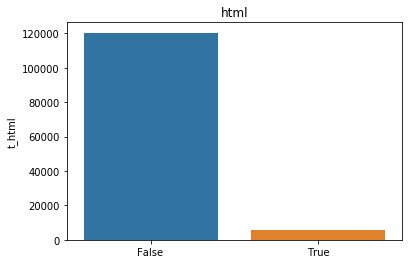

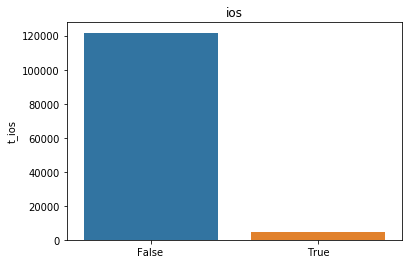

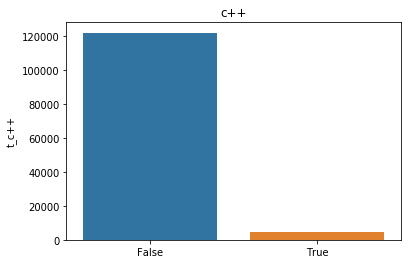

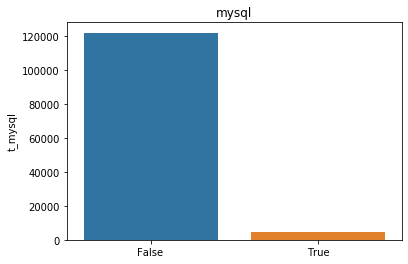

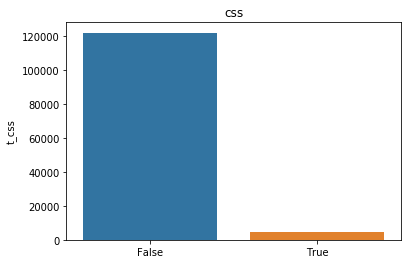

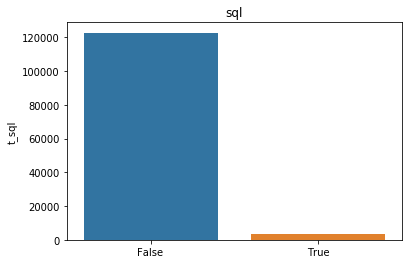

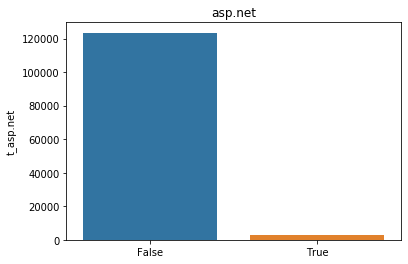

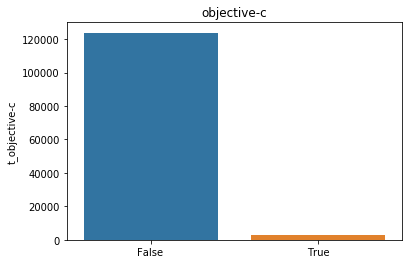

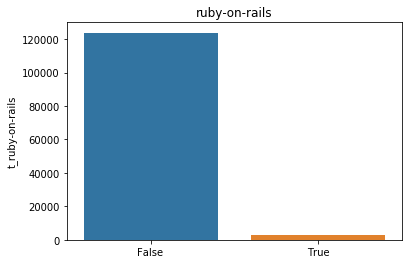

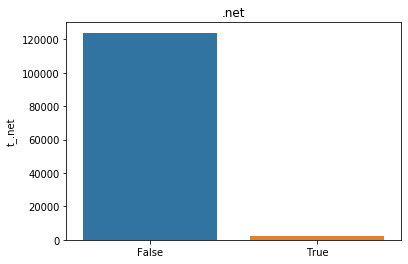

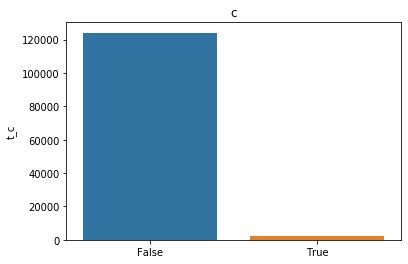

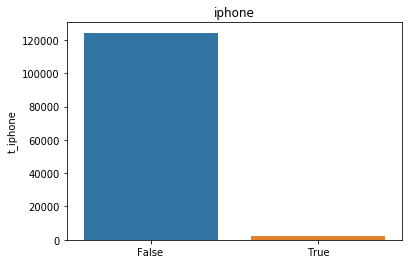

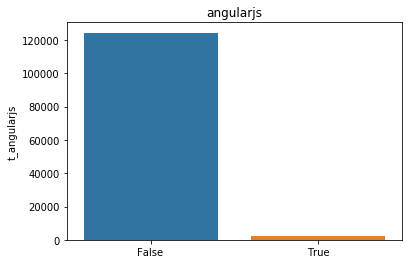

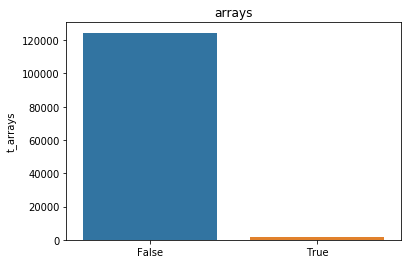

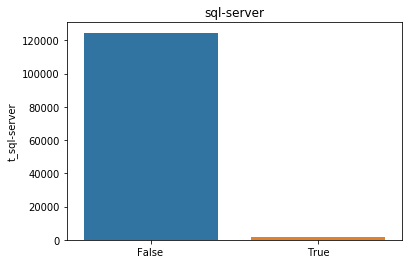

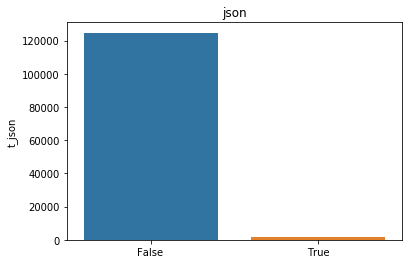

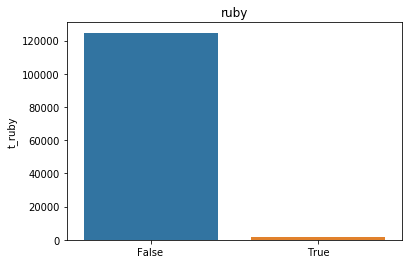

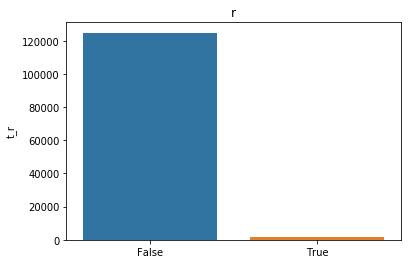

<Figure size 432x288 with 0 Axes>

In [29]:
explore_tags(q_data)

In [30]:
#Vectorizers para análisis de datos
vectorizer_cv_body_analysis = CountVectorizer(stop_words = "english", max_features = 100, analyzer=stemmed_words)
vectorizer_cv_title_analysis = CountVectorizer(stop_words = "english", max_features = 100, analyzer=stemmed_words)

In [31]:
cv_fit_body = vectorizer_cv_body_analysis.fit_transform(q_data.Body)
data_body = cv_fit_body.toarray().sum(axis=0)
indexes_body = vectorizer_cv_body_analysis.get_feature_names()

In [32]:
cv_fit_title = vectorizer_cv_title_analysis.fit_transform(q_data.Title)
data_title = cv_fit_title.toarray().sum(axis=0)
indexes_title = vectorizer_cv_title_analysis.get_feature_names()

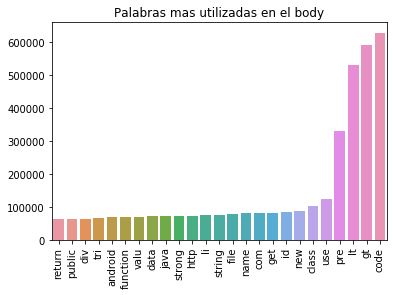

In [33]:
plot_top_words(indexes_body, data_body, 25, "Palabras mas utilizadas en el body")

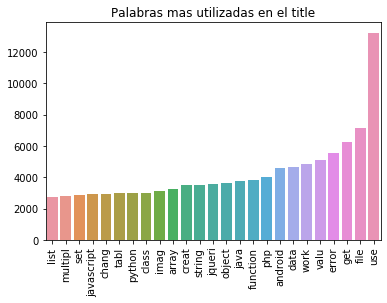

In [34]:
plot_top_words(indexes_title, data_title, 25, "Palabras mas utilizadas en el title")

# Data split y batching

In [35]:
def split_train_test_validation(df):
    df_train, df_test = train_test_split(df, test_size = 0.33,random_state=1)
    df_aux = df_train.copy()
    df_train, df_validation = train_test_split(df_aux, test_size = 0.33,random_state=1)
    return df_train, df_test.copy(), df_validation

### Data Sequence

In [36]:
# Esta clase se encarga de generar un batch 
# Le aplica a el batch solamente las transformaciones deseadas (fun_transform_) tanto a las features 'x'  como a 'y' 
class DataSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, fun_transform_x, fun_transform_y):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.transform_x = fun_transform_x
        self.transform_y = fun_transform_y

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size].reset_index(drop=True)
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size].reset_index(drop=True)
        #UPDATE 28/11
        return (self.transform_x(batch_x), (self.transform_y(batch_y)))

### Vectorizadores para Body y Title

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_cv_body = TfidfVectorizer(stop_words = "english", max_features = 200, analyzer=stemmed_words)

vectorizer_cv_title = TfidfVectorizer(stop_words = "english", max_features = 200, analyzer=stemmed_words)

### Funciones de transformacion de X e y

In [38]:
from scipy.sparse import hstack
from scipy.sparse import csc_matrix


def transform_x(batch_x):
    body_vectors = generate_vectors(batch_x[c_question],vectorizer_cv_body)
    title_vectors = generate_vectors(batch_x[c_title],vectorizer_cv_title)
    batch_x = hstack((body_vectors, title_vectors))
    return batch_x.todense()
    #Transformaciones aplicadas a las features predictoras antes de ser pasadas a la red
    pass

def transform_y(batch_y):
    add_tags_to_questions(batch_y, top_tags, top_tags_set)
    batch_y = batch_y.filter(regex=("t_.*"))
    return batch_y
    #Transformaciones aplicadas a las target labels antes de ser comparadas
    pass

In [39]:
def generate_vectors(column, vectorizer):
    X = vectorizer.transform(column)
    return X

### Particion de los datos en Train, Test y Validation

In [40]:
#UPDATE 28/11
q_train, q_test, q_validation = split_train_test_validation(q_data)

### Fit del lenguaje de Body y Title en sus vectorizers

In [41]:
vectorizer_cv_body.fit(q_train[c_question])
vectorizer_cv_title.fit(q_train[c_title])

TfidfVectorizer(analyzer=<function stemmed_words at 0x7fc3fa0ac1e0>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=200,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## Definicion de Loss y para modelos de  prediccion de tags (parte 1)

In [42]:
def get_weighted_loss(weights):
    def weighted_loss(y_true, y_pred):
        return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*K.binary_crossentropy(y_true, y_pred), axis=-1)
    return weighted_loss

In [43]:
#UPDATE 28/11
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

In [44]:
#UPDATE 28/11
y_real = transform_y(q_train)
class_weights = calculating_class_weights(np.array(y_real))

## Métricas de modelos de prediccion de tags (parte 1)

In [88]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def get_max_presicion_thresholds(y_true, y_pred):
    tags_count = y_pred.shape[1]
    max_thresholds = np.empty(tags_count)
    for i in range(tags_count):
        tag_pred = y_pred[:, i]
        tag_true = y_true[:, i]
        precisions, recalls, thresholds = precision_recall_curve(tag_true, tag_pred)
        j = precisions[:-1].argmax()
        max_thresholds[i] = thresholds[j]
    return max_thresholds

def macro_average_precision(ths, test, preds):
    precision_sum = 0
    for i in range(len(ths)):
        threshold = ths[i]
        tag_pred = preds[:,i]
        tag_pred = [1 if p >= threshold else 0 for p in tag_pred]
        tag_true = test[:,i]
        precision_sum =precision_sum + precision_score(tag_true, tag_pred)
    return precision_sum / len(ths)
        

# Model 

Definición del modelo baseline

In [46]:
batch_size_baseline = 500
generator = DataSequence(q_train, q_train, batch_size_baseline, transform_x, transform_y)
generator_validation = DataSequence(q_validation, q_validation, batch_size_baseline, transform_x, transform_y)

In [47]:
def get_baseline_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(2, activation='relu', input_shape=(input_size,)))
    #....
    model.add(Dense(output_size, activation='sigmoid'))
    
    #Update 28/11
    model.compile(loss=get_weighted_loss(class_weights), optimizer=SGD(), metrics=['accuracy'])
    return model

In [48]:
input_size_base_line = 400
output_size_base_line = 25
model = get_baseline_model(input_size_base_line, output_size_base_line)

# Train Baseline

In [49]:
#UPDATE 28/11
model.fit_generator(
    generator,
    workers = 10,
    use_multiprocessing = True,
    epochs=1,
    validation_data=generator_validation,
    validation_steps=len(generator_validation)
)

Epoch 1/1
114/114 [==============================] - 105s 917ms/step - loss: 0.6935 - accuracy: 0.0339 - val_loss: 0.7023 - val_accuracy: 0.0325


# Test Baseline 

In [51]:
generator_validation = DataSequence(q_validation, q_validation, batch_size_baseline, transform_x, transform_y)

preds_validation = model.predict_generator(generator_validation)


y_true_validation = transform_y(q_validation).to_numpy().astype(int)


ths = get_max_presicion_thresholds(y_true_validation, preds_validation)


generator_test = DataSequence(q_test, q_test, batch_size_baseline, transform_x, transform_y)

preds_test = model.predict_generator(generator_test)


y_true_test = transform_y(q_test).to_numpy().astype(int)



avg_validation = macro_average_precision(ths, y_true_validation, preds_validation)
avg_test = macro_average_precision(ths, y_true_test, preds_test)

print("Validation: "+ str(avg_validation))
print("Test: "+ str(avg_test))

Validation: 0.10132690420453423
Test: 0.02926243847658572


In [ ]:
y_test = transform_y(q_test)
y_test = y_test.to_numpy().astype(int)
len(y_test)

# Otros modelos
Entrenar y evaluar nuevos nuevos modelos buscando mejorar el baseline

In [52]:
def get_custom_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(input_size, activation='relu', input_shape=(input_size,)))
    model.add(Dense(int(input_size*0.75), activation='relu'))
    model.add(Dense(int(input_size*0.50), activation='relu'))
    #....
    model.add(Dense(output_size, activation='sigmoid'))
    
    #Update 28/11
    model.compile(loss=get_weighted_loss(class_weights), optimizer='adam')
    return model

In [53]:
input_size = 400
output_size = 25
custom_model_batch_size = 150

generator = DataSequence(q_train, q_train, custom_model_batch_size, transform_x, transform_y)
generator_validation = DataSequence(q_validation, q_validation, custom_model_batch_size, transform_x, transform_y)

model = get_custom_model(input_size, output_size)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                5025      
Total params: 345,925
Trainable params: 345,925
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.fit_generator(
    generator,
    workers = 10,
    use_multiprocessing = True,
    epochs=5,
    validation_data=generator_validation,
    validation_steps=len(generator_validation)
)

Epoch 1/5
379/379 [==============================] - 104s 275ms/step - loss: 0.3994 - val_loss: 0.2963
Epoch 2/5
379/379 [==============================] - 103s 271ms/step - loss: 0.3066 - val_loss: 0.2797
Epoch 3/5
379/379 [==============================] - 103s 273ms/step - loss: 0.2779 - val_loss: 0.2913
Epoch 4/5
379/379 [==============================] - 103s 271ms/step - loss: 0.2533 - val_loss: 0.2960
Epoch 5/5
379/379 [==============================] - 104s 274ms/step - loss: 0.2293 - val_loss: 0.3243


In [55]:
generator_validation = DataSequence(q_validation, q_validation, custom_model_batch_size, transform_x, transform_y)

preds_validation = model.predict_generator(generator_validation)


y_true_validation = transform_y(q_validation).to_numpy().astype(int)


ths = get_max_presicion_thresholds(y_true_validation, preds_validation)


generator_test = DataSequence(q_test, q_test, custom_model_batch_size, transform_x, transform_y)

preds_test = model.predict_generator(generator_test)


y_true_test = transform_y(q_test).to_numpy().astype(int)



avg_validation = macro_average_precision(ths, y_true_validation, preds_validation)
avg_test = macro_average_precision(ths, y_true_test, preds_test)

print("Validation: "+ str(avg_validation))
print("Test: "+ str(avg_test))

Validation: 0.9532320846662081
Test: 0.8388256794708842


# Parte 2

Pregunta seleccionada:
A partir de una pregunta y sus tags: ¿la pregunta va a ser cerrada?

In [56]:
c_closed = 'ClosedDate'
c_is_closed = 'Closed'

### Funciones de transformacion de X e y

In [58]:
def transform_x_2(batch_x):
    add_tags_to_questions(batch_x, top_tags, top_tags_set)
    tags = batch_x.filter(regex=("t_.*"))
    body_vectors = generate_vectors(batch_x[c_question],vectorizer_cv_body)
    title_vectors = generate_vectors(batch_x[c_title],vectorizer_cv_title)
    batch_x = hstack((body_vectors, title_vectors, tags))
    return batch_x.todense()
    #Transformaciones aplicadas a las features predictoras antes de ser pasadas a la red
    pass

def transform_y_2(batch_y):
    batch_y = np.where(batch_y[c_closed].isnull(), 0, 1)
    return batch_y
    #Transformaciones aplicadas a las target labels antes de ser comparadas
    pass

## Exploracion de datos

5653
120769


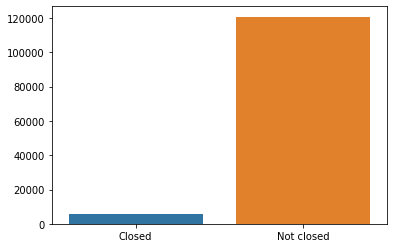

In [118]:
def plot_closed(y_class):
    count_1s = 0
    count_0s = 0
    for i in y_class:
        if i == 1:
            count_1s += 1
        else:
            count_0s += 1
    print(count_1s)
    print(count_0s)
    sns.barplot(x=["Closed", "Not closed"], y=[count_1s, count_0s])


y_true_2 = transform_y_2(q_data)     
plot_closed(y_true_2)

### Split de datos

In [57]:
q_train_2, q_test_2, q_validation_2 = split_train_test_validation(q_data)

### Calculo de Weight de las 2 clases a predecir

In [59]:
y_real_2 = transform_y_2(q_train_2)
class_weight_2 = np.empty([1, 2])
class_weight_2[0] = compute_class_weight('balanced', [0.,1.], y_real_2)
class_weight_2

array([[ 0.52303183, 11.35454182]])

### Construcción del modelo

In [102]:
input_size_2 = 425
output_size_2 = 1
closed_q_batch_size = 150

def get_custom_model_2(input_size, output_size):
    model = Sequential()
    model.add(Dense(input_size, activation='relu', input_shape=(input_size,)))
    model.add(Dense(int(input_size*1.5), activation='relu'))
    model.add(Dense(int(input_size*0.50), activation='relu'))
    model.add(Dense(output_size, activation='sigmoid'))
    
    model.compile(loss=get_weighted_loss(class_weight_2), optimizer='adam')
    return model

In [103]:
model_2 = get_custom_model_2(input_size_2, output_size_2)
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 425)               181050    
_________________________________________________________________
dense_24 (Dense)             (None, 637)               271362    
_________________________________________________________________
dense_25 (Dense)             (None, 212)               135256    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 213       
Total params: 587,881
Trainable params: 587,881
Non-trainable params: 0
_________________________________________________________________


In [104]:
generator_2 = DataSequence(q_train_2, q_train_2, closed_q_batch_size, transform_x_2, transform_y_2)
generator_validation_2 = DataSequence(q_validation_2, q_validation_2, closed_q_batch_size, transform_x_2, transform_y_2)

In [106]:
model_2.fit_generator(
    generator_2,
    workers = 10,
    use_multiprocessing = True,
    epochs=5,
    validation_data=generator_validation_2,
    validation_steps=len(generator_validation_2)
)

Epoch 1/5
379/379 [==============================] - 113s 297ms/step - loss: 0.2878 - val_loss: 1.1432
Epoch 2/5
379/379 [==============================] - 106s 280ms/step - loss: 0.1687 - val_loss: 1.1417
Epoch 3/5
379/379 [==============================] - 107s 283ms/step - loss: 0.1136 - val_loss: 1.8430
Epoch 4/5
379/379 [==============================] - 111s 293ms/step - loss: 0.0805 - val_loss: 2.2047
Epoch 5/5
379/379 [==============================] - 104s 276ms/step - loss: 0.0546 - val_loss: 3.4507


### Metricas del modelo

In [98]:
def get_max_threshold(y_true, y_pred):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    j = precisions[:-1].argmax()
    return thresholds[j]

In [107]:
generator_validation_2 = DataSequence(q_validation_2, q_validation_2, closed_q_batch_size, transform_x_2, transform_y_2)

preds_validation_2 = model_2.predict_generator(generator_validation_2)


y_true_validation_2 = transform_y_2(q_validation_2).astype(int)


th = get_max_threshold(y_true_validation_2,preds_validation_2)


generator_test_2 = DataSequence(q_test_2, q_test_2, closed_q_batch_size, transform_x_2, transform_y_2)

preds_test_2 = model_2.predict_generator(generator_test_2)
preds_test_2 = [1 if p >= th else 0 for p in preds_test_2]

y_true_test_2 = transform_y_2(q_test_2).astype(int)



In [117]:
precision = precision_score(y_true_test_2, preds_test_2)
recall = recall_score(y_true_test_2, preds_test_2)
report = classification_report(y_true_test_2, preds_test_2)

print('precision: ' + str(precision))
print('recall: '+ str(recall))
print('confusion matrix: ')
print(report)

precision: 1.0
recall: 0.003188097768331562
confusion matrix: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     39838
           1       1.00      0.00      0.01      1882

    accuracy                           0.96     41720
   macro avg       0.98      0.50      0.49     41720
weighted avg       0.96      0.96      0.93     41720

